<a href="https://colab.research.google.com/github/EliasNoorzad/XAI_Autonomous-Driving/blob/main/train/det%2Bseg_(no_attention).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive in Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


Install and use Ultralytics YOLO version 8.4.6 (used throughout the project)

In [ ]:
!pip -q install ultralytics==8.4.6



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.4 MB/s eta 0:00:00


Copy the dataset zip from Drive to the Colab workspace

In [ ]:
!cp /content/drive/MyDrive/XAI_Project/BDD100K_640.zip /content/


Unzip the dataset into /content/BDD100K

In [ ]:
!unzip -q /content/BDD100K_640.zip -d /content/BDD100K_640

Verify the dataset structure by listing sample train images, labels, and drivable-area masks.

In [ ]:
!ls /content/BDD100K_640/yolo_640/train/images | head
!ls /content/BDD100K_640/yolo_640/train/labels | head
!ls /content/BDD100K_640/drivable_masks_640/train | head


0000f77c-6257be58.jpg
0000f77c-62c2a288.jpg
0000f77c-cb820c98.jpg
0001542f-5ce3cf52.jpg
0001542f-7c670be8.jpg
0001542f-ec815219.jpg
0004974f-05e1c285.jpg
00054602-3bf57337.jpg
00067cfb-5443fe39.jpg
00067cfb-5adfaaa7.jpg
0000f77c-6257be58.txt
0000f77c-62c2a288.txt
0000f77c-cb820c98.txt
0001542f-5ce3cf52.txt
0001542f-7c670be8.txt
0001542f-ec815219.txt
0004974f-05e1c285.txt
00054602-3bf57337.txt
00067cfb-5443fe39.txt
00067cfb-5adfaaa7.txt
0000f77c-6257be58.png
0000f77c-62c2a288.png
0000f77c-cb820c98.png
0001542f-5ce3cf52.png
0001542f-7c670be8.png
0001542f-ec815219.png
0004974f-05e1c285.png
00054602-3bf57337.png
00067cfb-5443fe39.png
00067cfb-5adfaaa7.png


Create and save the YOLO dataset config file (dataset.yaml).

In [ ]:
yaml = """\
path: /content/BDD100K_640/yolo_640
train: train/images
val: val/images
test: test/images

nc: 5
names: [car, truck, bus, person, bike]
"""

with open("/content/BDD100K_640/yolo_640/dataset_640.yaml", "w") as f:
    f.write(yaml)


Define a custom PyTorch Dataset for the preprocessed BDD100K-640 setup, loading each sample as an RGB image tensor, its YOLO-format bounding-box labels, and a binary drivable-area mask for joint detection + segmentation.

In [ ]:
import numpy as np
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset


class BDDDetDrivableDataset(Dataset):
    """
    For preprocessed 640 dataset (yolo_640 + drivable_masks_640):
      images: <yolo_root>/<split>/images/<stem>.jpg
      labels: <yolo_root>/<split>/labels/<stem>.txt
      masks : <mask_root>/<split>/<stem>.png

    Returns:
      img   : FloatTensor [3, H, W] in [0,1]
      labels: FloatTensor [N, 5] where each row is [cls, x, y, w, h] (YOLO normalized)
      mask  : FloatTensor [1, H, W] with values 0/1
    """
    def __init__(self, yolo_root: str, mask_root: str, split: str, imgsz: int = 640):
        self.yolo_root = Path(yolo_root)
        self.mask_root = Path(mask_root)
        self.split = split
        self.imgsz = int(imgsz)

        self.img_dir = self.yolo_root / split / "images"
        self.lbl_dir = self.yolo_root / split / "labels"
        self.msk_dir = self.mask_root / split

        if not self.img_dir.is_dir():
            raise FileNotFoundError(f"Missing images dir: {self.img_dir}")
        if not self.lbl_dir.is_dir():
            raise FileNotFoundError(f"Missing labels dir: {self.lbl_dir}")
        if not self.msk_dir.is_dir():
            raise FileNotFoundError(f"Missing masks dir:  {self.msk_dir}")

        exts = {".jpg", ".jpeg", ".png"}
        self.img_paths = sorted([p for p in self.img_dir.iterdir() if p.suffix.lower() in exts])
        if len(self.img_paths) == 0:
            raise FileNotFoundError(f"No images found in: {self.img_dir}")

    def __len__(self):
        return len(self.img_paths)

    @staticmethod
    def _read_yolo_labels(label_path: Path) -> torch.Tensor:
        # YOLO txt lines: class x y w h
        if not label_path.exists():
            return torch.zeros((0, 5), dtype=torch.float32)

        rows = []
        with open(label_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                if len(parts) != 5:
                    continue
                cls, x, y, w, h = parts
                rows.append([float(cls), float(x), float(y), float(w), float(h)])

        if len(rows) == 0:
            return torch.zeros((0, 5), dtype=torch.float32)
        return torch.tensor(rows, dtype=torch.float32)

    @staticmethod
    def _pil_to_chw_float(img: Image.Image) -> torch.Tensor:
        arr = np.array(img, dtype=np.float32) / 255.0  # HWC
        arr = np.transpose(arr, (2, 0, 1))  # CHW
        return torch.from_numpy(arr)

    def __getitem__(self, idx: int):
        img_path = self.img_paths[idx]
        stem = img_path.stem

        label_path = self.lbl_dir / f"{stem}.txt"
        mask_path = self.msk_dir / f"{stem}.png"

        if not mask_path.exists():
            raise FileNotFoundError(f"Missing mask for {stem}: {mask_path}")

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # labels are already corrected for 640x640
        labels = self._read_yolo_labels(label_path)

        # optional safety check (won't change anything if already 640)
        if img.size != (self.imgsz, self.imgsz):
            img = img.resize((self.imgsz, self.imgsz), resample=Image.BILINEAR)
        if mask.size != (self.imgsz, self.imgsz):
            mask = mask.resize((self.imgsz, self.imgsz), resample=Image.NEAREST)

        img_t = self._pil_to_chw_float(img)  # [3,H,W]
        mask_np = (np.array(mask, dtype=np.uint8) > 0).astype(np.float32)
        mask_t = torch.from_numpy(mask_np)[None, :, :]  # [1,H,W]

        return img_t, labels, mask_t


Dataset sanity check: image tensor is [3,640,640] normalized to [0,1], labels have shape [2,5] (two YOLO boxes in this specific example), and the drivable mask is binary with shape [1,640,640].

In [ ]:
ds = BDDDetDrivableDataset(
    yolo_root="/content/BDD100K_640/yolo_640",
    mask_root="/content/BDD100K_640/drivable_masks_640",
    split="train",
    imgsz=640
)

img, labels, mask = ds[0]
print(img.shape, labels.shape, mask.shape)
print(img.min().item(), img.max().item(), mask.unique())


torch.Size([3, 640, 640]) torch.Size([2, 5]) torch.Size([1, 640, 640])
0.0 1.0 tensor([0., 1.])


Visualize one training sample with the drivable-area mask overlay and its YOLO bounding boxes drawn on the image.

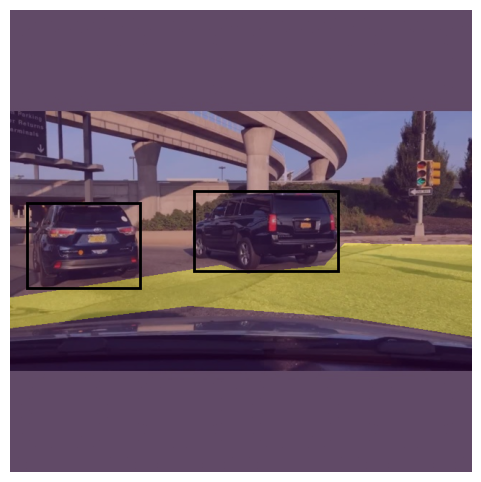

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

img, labels, mask = ds[0]
im = img.permute(1,2,0).numpy()
m  = mask[0].numpy()

plt.figure(figsize=(6,6))
plt.imshow(im)
plt.imshow(m, alpha=0.35)
plt.axis("off")

# draw boxes (labels are normalized to 640x640)
H, W = 640, 640
for row in labels:
    cls, x, y, w, h = row.tolist()
    x1 = (x - w/2) * W
    y1 = (y - h/2) * H
    bw = w * W
    bh = h * H
    plt.gca().add_patch(plt.Rectangle((x1,y1), bw, bh, fill=False, linewidth=2))

plt.show()


Define the joint YOLOv8 detection + drivable-area segmentation model by hooking YOLO’s neck features (Detect input) and adding a lightweight segmentation head for training and inference.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from ultralytics import YOLO


class YOLOv8DetSemSeg(nn.Module):
    """
    YOLOv8 detection model + tiny semantic seg head.
    Captures NECK features by hooking the Detect head INPUT (multi-scale features).
    """
    def __init__(self, yolo_weights: str = "yolov8n.pt"):
        super().__init__()
        self.yolo = YOLO(yolo_weights).model  # nn.Module
        self._neck_feats = None

        self.sem_head = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1)
        )

        self._register_detect_input_hook()

    def _register_detect_input_hook(self):
        if not hasattr(self.yolo, "model"):
            raise RuntimeError("Unexpected Ultralytics model: no .model")

        detect_module = self.yolo.model[-1]
        name = detect_module.__class__.__name__.lower()
        if "detect" not in name:
            raise RuntimeError(f"Last module is not Detect (got {detect_module.__class__.__name__}).")

        # remove previous hook if exists
        if hasattr(self, "_detect_hook_handle") and self._detect_hook_handle is not None:
            self._detect_hook_handle.remove()

        def pre_hook(module, inputs):
            self._neck_feats = inputs[0]

        self._detect_hook_handle = detect_module.register_forward_pre_hook(pre_hook)


    @staticmethod
    def _pick_high_res_from_detect_inputs(feats):
        # feats: list/tuple of [B,C,H,W]
        if not isinstance(feats, (list, tuple)) or len(feats) == 0:
            raise RuntimeError("Detect input features not captured.")
        return max(feats, key=lambda t: t.shape[-2] * t.shape[-1])  # highest H*W (usually P3)

    def forward(self, x):
      # TRAIN: x is a batch dict -> YOLO returns (det_loss, loss_items)
      if isinstance(x, dict):
          self._neck_feats = None
          imgs = x["img"]
          det_loss, det_items = self.yolo(x)

          feat = self._pick_high_res_from_detect_inputs(self._neck_feats)
          seg_logits = self.sem_head(feat)
          seg_logits = F.interpolate(seg_logits, size=imgs.shape[-2:], mode="bilinear", align_corners=False)
          return det_loss, det_items, seg_logits

      # INFER: x is an image tensor -> YOLO returns preds
      self._neck_feats = None
      det_preds = self.yolo(x)

      feat = self._pick_high_res_from_detect_inputs(self._neck_feats)
      seg_logits = self.sem_head(feat)
      seg_logits = F.interpolate(seg_logits, size=x.shape[-2:], mode="bilinear", align_corners=False)
      return det_preds, seg_logits


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Run a forward pass through the joint model to verify the segmentation head output is a single-channel logit map of shape [1, 1, 640, 640].

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = YOLOv8DetSemSeg(
    yolo_weights="/content/drive/MyDrive/XAI_Project/experiments/det_baseline/weights/best.pt"
).to(device)

img, labels, mask = ds[0]
x = img.unsqueeze(0).to(device)

det_out, seg_logits = model(x)
print(seg_logits.shape)  # should be [1, 1, 640, 640]


torch.Size([1, 1, 640, 640])


Define a custom collate function that batches images and masks and packs variable-length YOLO labels into the format expected for joint detection + segmentation training.

In [ ]:
import torch

def collate_det_seg(batch):
    imgs, labels_list, masks = zip(*batch)
    imgs = torch.stack(imgs, 0)
    masks = torch.stack(masks, 0)

    bboxes_all, cls_all, batch_idx_all = [], [], []
    for i, lab in enumerate(labels_list):
        if lab.numel() == 0:
            continue
        cls = lab[:, 0:1].long()     # FIX
        bboxes = lab[:, 1:5].float() # keep float
        bboxes_all.append(bboxes)
        cls_all.append(cls)
        batch_idx_all.append(torch.full((lab.shape[0],), i, dtype=torch.long))

    if len(bboxes_all):
        bboxes = torch.cat(bboxes_all, 0)
        cls = torch.cat(cls_all, 0)
        batch_idx = torch.cat(batch_idx_all, 0)
    else:
        bboxes = torch.zeros((0, 4), dtype=torch.float32)
        cls = torch.zeros((0, 1), dtype=torch.long)   # FIX
        batch_idx = torch.zeros((0,), dtype=torch.long)

    return {"img": imgs, "bboxes": bboxes, "cls": cls, "batch_idx": batch_idx, "mask": masks}


Training loop for one epoch using mixed precision, combining YOLO detection loss and segmentation BCE loss with a weighted factor lambda_seg.

In [ ]:
import torch
import torch.nn.functional as F

def train_one_epoch(model, loader, optimizer, device, scaler, lambda_seg=1.0):
    model.train()
    tot_loss = 0.0
    tot_det  = 0.0
    tot_seg  = 0.0

    for batch in loader:
        img  = batch["img"].to(device, non_blocking=True)
        mask = batch["mask"].to(device, non_blocking=True)

        det_batch = {
            "img": img,
            "cls": batch["cls"].to(device, non_blocking=True),
            "bboxes": batch["bboxes"].to(device, non_blocking=True),
            "batch_idx": batch["batch_idx"].to(device, non_blocking=True),
        }

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type="cuda", enabled=(device == "cuda")):
            det_loss, _, seg_logits = model(det_batch)
            det_loss = det_loss.mean()
            seg_loss = F.binary_cross_entropy_with_logits(seg_logits, mask)
            loss = det_loss + lambda_seg * seg_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        tot_loss += loss.item()
        tot_det  += det_loss.item()
        tot_seg  += seg_loss.item()

    n = max(1, len(loader))
    return (tot_loss / n), (tot_det / n), (tot_seg / n)


Validation function that computes mean IoU for drivable-area segmentation by thresholding predicted logits and comparing them to the ground-truth masks.

In [ ]:
import torch

@torch.no_grad()
def val_iou(model, loader, device, max_batches=None):
    model.eval()
    total_iou = 0.0
    total_imgs = 0

    for bi, batch in enumerate(loader):
        if (max_batches is not None) and (bi >= max_batches):
            break

        img = batch["img"].to(device)
        gt  = (batch["mask"].to(device) > 0.5).float()

        _, seg_logits = model(img)
        pred = (torch.sigmoid(seg_logits) > 0.5).float()

        inter = (pred * gt).sum(dim=(1, 2, 3))
        union = ((pred + gt) > 0).float().sum(dim=(1, 2, 3)).clamp_min(1.0)

        iou = (inter / union)  # [B]
        total_iou += iou.sum().item()
        total_imgs += iou.numel()

    return total_iou / max(1, total_imgs)


Initialize the training split of the detection+drivable segmentation dataset (640×640).

In [ ]:
train_ds = BDDDetDrivableDataset(
    yolo_root="/content/BDD100K_640/yolo_640",
    mask_root="/content/BDD100K_640/drivable_masks_640",
    split="train",
    imgsz=640
)


Build the training DataLoader with the custom collate function for joint detection + segmentation batches.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=False,
    persistent_workers=True,
    collate_fn=collate_det_seg
)


Initialize an Ultralytics DetectionTrainer to build the detection model with its correct training args and loss criterion, then replace the joint model’s internal YOLO module with this trainer-built model and re-register the Detect-input hook so neck features are still captured after the swap.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
from ultralytics.models.yolo.detect.train import DetectionTrainer

trainer = DetectionTrainer(overrides={
    "model": "/content/drive/MyDrive/XAI_Project/experiments/det_baseline/weights/best.pt",
    "data":  "/content/BDD100K_640/yolo_640/dataset_640.yaml",
    "imgsz": 640,
    "device": 0,
})
trainer.setup_model()
trainer.model.args = trainer.args
trainer.model.init_criterion()

# 1) swap first
model.yolo = trainer.model.to(device)

# 2) then re-register hook on the NEW model.yolo
model._neck_feats = None
model._register_detect_input_hook()


Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/BDD100K_640/yolo_640/dataset_640.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/XAI_Project/experiments/det_baseline/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=Fal

Set up the AdamW optimizer for joint training (learning rate 1e-4, weight decay 5e-4)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)

Create the validation dataset and DataLoader for evaluating drivable-area IoU during training.

In [ ]:
val_ds = BDDDetDrivableDataset(
    yolo_root="/content/BDD100K_640/yolo_640",
    mask_root="/content/BDD100K_640/drivable_masks_640",
    split="val",
    imgsz=640
)

from torch.utils.data import DataLoader
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=False,
    collate_fn=collate_det_seg
)

Train the no-attention joint model for 30 epochs with AMP and checkpointing: resume from last.ckpt if available, validate IoU every 2 epochs on ~1000 validation images, and save epoch snapshots, best weights, and a resume checkpoint.

In [ ]:
import os
import torch

# ---------- PATHS ----------
save_root = "/content/drive/MyDrive/XAI_Project/experiments/det_seg_noatt_640/weights"
os.makedirs(save_root, exist_ok=True)

best_path = os.path.join(save_root, "best.pt")
ckpt_path = os.path.join(save_root, "last.ckpt")

# ---------- AMP SCALER ----------
scaler = torch.cuda.amp.GradScaler()

# ---------- RESUME (optional) ----------
start_epoch = 1
best_iou = -1.0

if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    best_iou = ckpt.get("best_iou", -1.0)
    if "scaler" in ckpt:
        scaler.load_state_dict(ckpt["scaler"])
    start_epoch = int(ckpt["epoch"]) + 1
    print(f"Resuming from epoch {start_epoch} | best_iou={best_iou:.4f}", flush=True)

# ---------- TRAIN ----------
epochs = 30
lambda_seg = 0.01

for epoch in range(start_epoch, epochs + 1):
    train_total, train_det, train_seg = train_one_epoch(
        model=model,
        loader=train_loader,
        optimizer=optimizer,
        device=device,
        scaler=scaler,          # <-- AMP
        lambda_seg=lambda_seg
    )

    # validate every 2 epochs (subset for speed)
    if epoch % 2 == 0:
        iou = val_iou(model, val_loader, device, max_batches=125)  # ~1000 imgs if batch=8
        iou_str = f"{iou:.4f}"
        # SAVE SNAPSHOT EVERY VALIDATION
        snap_path = os.path.join(save_root, f"epoch{epoch:02d}.pt")
        torch.save(model.state_dict(), snap_path)
        print(f"  saved SNAPSHOT: {snap_path}", flush=True)
    else:
        iou = None
        iou_str = "skip"

    print(
        f"epoch {epoch:02d}/{epochs} | "
        f"train total={train_total:.4f} det={train_det:.4f} seg={train_seg:.4f} | "
        f"val_iou={iou_str}",
        flush=True
    )

    # save BEST only when iou was computed
    if (iou is not None) and (iou > best_iou):
        best_iou = iou
        torch.save(model.state_dict(), best_path)
        print(f"  saved BEST: {best_path} (best_iou={best_iou:.4f})", flush=True)

    # save LAST (resume checkpoint)
    torch.save({
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "best_iou": best_iou,
        "scaler": scaler.state_dict(),
    }, ckpt_path)

/tmp/ipython-input-356603874.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Resuming from epoch 22 | best_iou=0.6410
  saved SNAPSHOT: /content/drive/MyDrive/XAI_Project/experiments/det_seg_noatt_640/weights/epoch22.pt
epoch 22/30 | train total=6.6405 det=6.6400 seg=0.0573 | val_iou=0.6143
epoch 23/30 | train total=6.6182 det=6.6176 seg=0.0582 | val_iou=skip
  saved SNAPSHOT: /content/drive/MyDrive/XAI_Project/experiments/det_seg_noatt_640/weights/epoch24.pt
epoch 24/30 | train total=6.5985 det=6.5979 seg=0.0588 | val_iou=0.6005
epoch 25/30 | train total=6.5748 det=6.5742 seg=0.0593 | val_iou=skip
  saved SNAPSHOT: /content/drive/MyDrive/XAI_Project/experiments/det_seg_noatt_640/weights/epoch26.pt
epoch 26/30 | train total=6.5511 det=6.5505 seg=0.0598 | val_iou=0.5917
epoch 27/30 | train total=6.5358 det=6.5352 seg=0.0604 | val_iou=skip
  saved SNAPSHOT: /content/drive/MyDrive/XAI_Project/experiments/det_seg_noatt_640/weights/epoch28.pt
epoch 28/30 | train total=6.5124 det=6.5118 seg=0.0605 | val_iou=0.5978
epoch 29/30 | train total=6.4949 det=6.4943 seg=0.060

Evaluate the detection baseline on the validation split and report mAP50 and mAP50–95 for comparison against our new models/results.

In [ ]:
from ultralytics import YOLO
BASE = YOLO("/content/drive/MyDrive/XAI_Project/experiments/det_baseline/weights/best.pt")
m_base = BASE.val(data="/content/BDD100K_640/yolo_640/dataset_640.yaml", imgsz=640, device=0)
print("BASE mAP50 =", m_base.box.map50, "mAP50-95 =", m_base.box.map)


Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 77.4±51.1 MB/s, size: 62.1 KB)
val: Scanning /content/BDD100K_640/yolo_640/val/labels... 10000 images, 80 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10000/10000 1.4Kit/s 7.0s
val: New cache created: /content/BDD100K_640/yolo_640/val/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 625/625 5.9it/s 1:45
                   all      10000     122617      0.655      0.481      0.539      0.336
                person       9879     102506      0.751      0.689      0.748      0.459
                   car       2689       4245      0.654      0.497      0.563      0.403
                  bike       1242       1597      0.641      0.468       0.54      0.416
                   bus       3220      13262       0.67    

Load the best joint model checkpoint and compute the full validation IoU for drivable-area segmentation.

In [ ]:
import torch

best_pt = "/content/drive/MyDrive/XAI_Project/experiments/det_seg_noatt_640/weights/best.pt"
sd = torch.load(best_pt, map_location="cpu")
model.load_state_dict(sd, strict=True)   # wrapper weights (yolo + sem_head)
model.to(device)

iou_full = val_iou(model, val_loader, device, max_batches=None)
print("val_iou_full =", iou_full)


val_iou_full = 0.6601302074551583


Load the joint model checkpoint, extract its detection (YOLO) weights, and evaluate detection performance on the validation split to compare against the baseline.

In [ ]:
import torch
from ultralytics import YOLO

# det+seg checkpoint
pt = "/content/drive/MyDrive/XAI_Project/experiments/det_seg_noatt_640/weights/best.pt"
sd = torch.load(pt, map_location="cpu")

# building a YOLO object (just to get Ultralytics val() + Results formatting)
y = YOLO("/content/drive/MyDrive/XAI_Project/experiments/det_baseline/weights/best.pt")

# injecting YOLO weights that were trained inside det+seg
yolo_sd = {k.replace("yolo.", ""): v for k, v in sd.items() if k.startswith("yolo.")}
y.model.load_state_dict(yolo_sd, strict=True)

# evaluating detection on the SAME 640 dataset yaml we trained on
m = y.val(data="/content/BDD100K_640/yolo_640/dataset_640.yaml", imgsz=640, device=0)

print("DET mAP50 =", m.box.map50)
print("DET mAP50-95 =", m.box.map)


Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1203.2±468.3 MB/s, size: 67.4 KB)
val: Scanning /content/BDD100K_640/yolo_640/val/labels.cache... 10000 images, 80 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10000/10000 1.0Git/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 625/625 6.1it/s 1:43
                   all      10000     122617      0.632       0.47       0.52      0.312
                person       9879     102506      0.777      0.664      0.742      0.446
                   car       2689       4245      0.583        0.5       0.52      0.359
                  bike       1242       1597      0.625      0.446      0.507      0.367
                   bus       3220      13262      0.692      0.433       0.51      0.239
                 truck        57

Generate qualitative validation overlays by running the joint model to predict the drivable-area mask and the jointly-trained detection head to predict boxes, then saving combined mask+box visualizations for selected val images.

In [ ]:
# OVERLAYS: predicted drivable mask + predicted YOLO boxes (VAL samples)

import os, random
import numpy as np
import torch
from PIL import Image, ImageDraw
import yaml

from ultralytics import YOLO

# CONFIG
best_pt   = "/content/drive/MyDrive/XAI_Project/experiments/det_seg_noatt_640/weights/best.pt"
det_shell = "/content/drive/MyDrive/XAI_Project/experiments/det_baseline/weights/best.pt"  # just a YOLO container
out_dir   = "/content/drive/MyDrive/XAI_Project/experiments/det_seg_noatt_640/overlays_val_mat"
N         = 20
CONF      = 0.50

os.makedirs(out_dir, exist_ok=True)

# LOAD WRAPPER (seg + yolo inside wrapper)
sd = torch.load(best_pt, map_location="cpu")
model.load_state_dict(sd, strict=True)
model.to(device).eval()

# LOAD YOLO EVAL MODEL WITH YOUR DET+SEG TRAINED YOLO WEIGHTS
y = YOLO(det_shell)
with open("/content/BDD100K_640/yolo_640/dataset_640.yaml", "r") as f:
    names = yaml.safe_load(f)["names"]

y.model.names = {i: n for i, n in enumerate(names)}
yolo_sd = {k.replace("yolo.", ""): v for k, v in sd.items() if k.startswith("yolo.")}
y.model.load_state_dict(yolo_sd, strict=True)

def overlay_mask_rgb(im_rgb_u8: np.ndarray, mask01: np.ndarray, alpha=0.35):
    # im_rgb_u8: HxWx3 uint8, mask01: HxW {0,1}
    im = im_rgb_u8.astype(np.float32)
    ov = im.copy()
    red = np.array([255, 0, 0], dtype=np.float32)
    ov[mask01 > 0] = (1 - alpha) * ov[mask01 > 0] + alpha * red
    return np.clip(ov, 0, 255).astype(np.uint8)


import re, glob

cbam_dir = "/content/drive/MyDrive/XAI_Project/experiments/det_seg_dn_cbam_640/att_seg_dn_overlays_5"
cbam_files = glob.glob(os.path.join(cbam_dir, "val_*_attFUSED_globalNORM_seg.png"))

idxs = []
for p in cbam_files:
    m = re.search(r"val_(\d+)_", os.path.basename(p))
    if m:
        idxs.append(int(m.group(1)))

idxs = [6029]

print("Using idxs from CBAM overlays:", idxs)



for idx in idxs:

    base_path = os.path.join(cbam_dir, f"val_{idx:05d}_BASE.png")
    img_np = np.array(Image.open(base_path).convert("RGB"))        # HxWx3 uint8
    img_t  = torch.from_numpy(img_np).permute(2,0,1).float() / 255.0


    # seg prediction
    x = img_t.unsqueeze(0).to(device)
    _, seg_logits = model(x)
    pred_mask = (torch.sigmoid(seg_logits)[0,0] > 0.5).detach().cpu().numpy().astype(np.uint8)

    # YOLO prediction (det head trained alongside seg)
    res = y.predict(source=img_np, imgsz=640, conf=CONF, device=0, verbose=False)[0]

    # drawing overlay
    over_np = overlay_mask_rgb(img_np, pred_mask, alpha=0.35)
    Image.fromarray(img_np).save(os.path.join(out_dir, f"val_{idx:05d}_BASE.png"))

    im_pil = Image.fromarray(over_np)
    draw = ImageDraw.Draw(im_pil)

    if res.boxes is not None and len(res.boxes) > 0:
        xyxy = res.boxes.xyxy.cpu().numpy()
        cls  = res.boxes.cls.cpu().numpy().astype(int)
        conf = res.boxes.conf.cpu().numpy()
        names = res.names  # dict

        for (x1,y1,x2,y2), c, cf in zip(xyxy, cls, conf):
            draw.rectangle([x1,y1,x2,y2], outline=(0,255,0), width=2)
            draw.text((x1, max(0, y1-12)), f"{names.get(c,c)} {cf:.2f}", fill=(0,255,0))

    name = f"idx_{idx:05d}"
    out_path = os.path.join(out_dir, f"{name}.png")


    im_pil.save(out_path)

print("Saved overlays to:", out_dir)


Using idxs from CBAM overlays: [6029]
Saved overlays to: /content/drive/MyDrive/XAI_Project/experiments/det_seg_noatt_640/overlays_val_mat
